**关于该Notebook**

任务: 以沪深300数据集为例，使用scutquant包完成从原始数据到因子，再到拟合模型和回测的全过程。具体包括:  

(1)、使用**scutquant**(scutquant包下面的一个模块)和**alpha**构造目标值和因子，并自动完成特征工程和数据清洗(包括拆分数据集、填充和去除缺失值、标准化、截断异常值、重采样和降采样、特征筛选和正则化)  

(2)、使用**scutquant**一键建模(以lightgbm为例) 

(3)、使用**scutquant**的ic_ana计算IC、Rank IC和pearson相关系数等指标，并评价模型拟合情况(指标越高越好), IC的计算方式为  
 $$IC(t) = PearsonCorr(predict_{t}, y_{t})$$  
 其中, $PearsonCorr(x, y) = \frac{cov(x,y)}{\sqrt{\sigma_x * \sigma_y}}$, $predict_t$ 为t时刻所有资产的预测值序列(即截面上的预测值), 同理$y_t$ 为截面上的真实值
 
(4)、判断多因子在该模型下是否有效的t检验为 $t = ICIR * \sqrt{\Delta T}$, 其中$ICIR=\frac{\bar{IC}}{\sigma{IC}}$, $\Delta T$为时间间隔(例如测试集的天数). 该方法仅在IC分布为正态分布时成立(ic_ana会输出IC序列的分布图)  

(5)、使用**report**模块查看分组情况(按照每个time_tick的预测情况，对所有资产从高到低分成n组，并计算它们的累计平均收益率)。如果Group1到Group5呈现了明显的单调性(几条曲线交错很少, 且1~5由高到低呈现)则说明因子和模型的选股能力较强，因子较有效.  

5.1、其中, long-short为做多Group1(预测值最高)做空Group5(预测值最低)的累计收益，long-average为做多Group1并无差别做空资产池的累计收益(因为中国股市严格限制做空，因此long-short的收益难以实现，但是可以通过做空股指期货的做法实现套利, 而average对应的就是股指期货)，并给出预测的准确率($predict_{i,t}>=0$且$y_{i,t}>=0$或$predict_{i,t}<0$且$y_{i,t}<0$则为正确，否则为错误)  

(6)、使用**executor**模块执行回测, 需要在字典中写好策略和其它必要的参数, 并使用**report**模块报告回测结果  

In [1]:
# 导入需要用到的库
import pandas as pd
import scutquant.scutquant as q
from scutquant import alpha, report, executor

样例数据集只有基础的价量数据，以面板数据的形式呈现. 当需要额外数据构建因子时(例如需要构建市场因子Rm), 就需要读取supplemental data. 当补充数据为时序数据时，可以使用join_data函数将其合并到数据集中；当补充数据为各个股票的截面数据时，可以使用join_data_by_code按股票代码将数据合并到数据集中

In [2]:
# 读取数据
df = pd.read_csv("D:/Desktop/data.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df["mean_price"] = df["amount"] / df["vol"] * 10  # 每支股票在当天的交易均价
df.set_index(["datetime", "ts_code"], inplace=True)
df.index.names = ["datetime", "instrument"]
df["volume"] = df["vol"]
df

open    high     low   close  pre_close  change  \
datetime   instrument                                                      
2006-01-04 000001.SZ     6.13    6.33    6.12    6.28       6.14    0.14   
           000002.SZ     4.40    4.67    4.40    4.66       4.31    0.35   
           000012.SZ     4.70    4.75    4.55    4.70       4.62    0.08   
           000016.SZ     3.52    3.58    3.52    3.57       3.52    0.05   
           000021.SZ     7.99    8.40    7.99    8.32       8.00    0.32   
...                       ...     ...     ...     ...        ...     ...   
2022-12-30 688363.SH   136.00  137.00  131.50  135.28     135.49   -0.21   
           688396.SH    53.06   53.40   52.49   52.65      52.87   -0.22   
           688561.SH    65.49   67.88   64.85   65.77      65.46    0.31   
           688599.SH    63.31   64.56   62.31   63.76      63.20    0.56   
           688981.SH    41.01   41.35   41.01   41.14      40.89    0.25   

                       pct_chg        vol       amount  mean_price     volume  
datetime   instrument                                                          
2006-01-04 000001.SZ    2.2800  154450.68   96989.0066    6.279610  154450.68  
           000002.SZ    8.1200  389310.43  175187.0657    4.499933  389310.43  
           000012.SZ    1.7300   40399.61   18863.8625    4.669318   40399.61  
           000016.SZ    1.4200   14426.65    5131.8793    3.557222   14426.65  
           000021.SZ    4.0000   33526.60   27657.1708    8.249322   33526.60  
...                        ...        ...          ...         ...        ...  
2022-12-30 688363.SH   -0.1550   29951.60  401624.1560  134.091052   29951.60  
           688396.SH   -0.4161   23401.54  123568.2880   52.803486   23401.54  
           688561.SH    0.4736   22567.89  149379.0770   66.190981   22567.89  
           688599.SH    0.8861  109144.36  695759.9350   63.746760  109144.36  
           688981.SH    0.6114   60396.11  248594.8820   41.160744   60396.11  

[1199445 rows x 11 columns]

**关于目标值:** 为了避免数据泄露和其它各种问题，我们构建的目标值应尽量与已知数据无关(即$y_t$无法用已知的数据${X_t, X_{t-1}, ...}$计算得到). 这里我们选择$label = \frac{close_{-2}}{close_{-1}} - 1$, 即T时刻需要预测的目标值是T+2相对于T+1的收益率, 现实意义是在今天(T)作出预测, 并在明天(T+1)以收盘价开仓, 后天(T+2)以收盘价平仓  

**关于因子:** 参考alpha模块中的make_factors()和alpha360(), 前者主要为技术指标, 后者是原始量价数据的滞后项除单位, 目的是让模型在张成的360维空间中自行发掘因子

In [3]:
# 构造目标值
df["label"] = df["pct_chg"].groupby("instrument").shift(-2) / 100
df = df.dropna() 

In [4]:
X = alpha.qlib158(df)
X = pd.concat([X, df[["label"]]], axis=1)
X

open5    open10    open20    open30    open60  \
datetime   instrument                                                     
2006-01-04 000001.SZ        NaN       NaN       NaN       NaN       NaN   
           000002.SZ        NaN       NaN       NaN       NaN       NaN   
           000012.SZ        NaN       NaN       NaN       NaN       NaN   
           000016.SZ        NaN       NaN       NaN       NaN       NaN   
           000021.SZ        NaN       NaN       NaN       NaN       NaN   
...                         ...       ...       ...       ...       ...   
2022-12-28 688363.SH   0.904552  0.919185  0.822119  0.822487  0.983087   
           688396.SH   1.023019  1.107547  0.997925  1.031887  0.905660   
           688561.SH   0.941356  0.967251  0.944402  1.035796  0.712871   
           688599.SH   0.874043  0.893973  1.029974  1.053890  1.084024   
           688981.SH   1.020293  1.074817  1.005134  1.046210  0.933496   

                         close5   close10   close20   close30   close60  ...  \
datetime   instrument                                                    ...   
2006-01-04 000001.SZ        NaN       NaN       NaN       NaN       NaN  ...   
           000002.SZ        NaN       NaN       NaN       NaN       NaN  ...   
           000012.SZ        NaN       NaN       NaN       NaN       NaN  ...   
           000016.SZ        NaN       NaN       NaN       NaN       NaN  ...   
           000021.SZ        NaN       NaN       NaN       NaN       NaN  ...   
...                         ...       ...       ...       ...       ...  ...   
2022-12-28 688363.SH   0.913302  0.950805  0.797117  0.833811  0.978013  ...   
           688396.SH   1.014528  1.074906  1.001887  1.015094  0.898868  ...   
           688561.SH   0.938309  0.992993  0.929170  1.036253  0.673724  ...   
           688599.SH   0.855389  0.871492  1.028380  1.055166  1.064573  ...   
           688981.SH   1.009535  1.040831  0.998533  1.038631  0.923961  ...   

                         vstd10    vstd20    vstd30    vstd60    vsump5  \
datetime   instrument                                                     
2006-01-04 000001.SZ        NaN       NaN       NaN       NaN       NaN   
           000002.SZ        NaN       NaN       NaN       NaN       NaN   
           000012.SZ        NaN       NaN       NaN       NaN       NaN   
           000016.SZ        NaN       NaN       NaN       NaN       NaN   
           000021.SZ        NaN       NaN       NaN       NaN       NaN   
...                         ...       ...       ...       ...       ...   
2022-12-28 688363.SH   0.335861  0.565374  0.531419  0.505447  2.125565   
           688396.SH   0.612528  0.960918  0.850216  0.883390  6.701911   
           688561.SH   0.446123  0.576459  0.566023  0.986210  2.832572   
           688599.SH   0.233004  0.570362  0.490549  0.418439  3.177258   
           688981.SH   0.670812  0.988867  0.862481  1.331351  7.003635   

                        vsump10   vsump20   vsump30   vsump60     label  
datetime   instrument                                                    
2006-01-04 000001.SZ        NaN       NaN       NaN       NaN  0.014200  
           000002.SZ        NaN       NaN       NaN       NaN -0.006400  
           000012.SZ        NaN       NaN       NaN       NaN  0.000000  
           000016.SZ        NaN       NaN       NaN       NaN  0.002700  
           000021.SZ        NaN       NaN       NaN       NaN -0.003600  
...                         ...       ...       ...       ...       ...  
2022-12-28 688363.SH   2.857149  3.390439  3.229916  3.246918 -0.001550  
           688396.SH   4.633796  4.138890  4.306676  3.909970 -0.004161  
           688561.SH   3.468652  3.758971  3.914736  3.579458  0.004736  
           688599.SH   4.161507  2.939557  3.262855  3.828687  0.008861  
           688981.SH   3.761994  3.101441  3.357498  3.368421  0.006114  

[1197673 rows x 140 columns]

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1197673 entries, (Timestamp('2006-01-04 00:00:00'), '000001.SZ') to (Timestamp('2022-12-28 00:00:00'), '688981.SH')
Columns: 140 entries, open5 to label
dtypes: float64(140)
memory usage: 1.3+ GB
None
X_mis= 1.736435094196353
clean dataset done 

split data done 

label norm done 

The distribution of y_train:


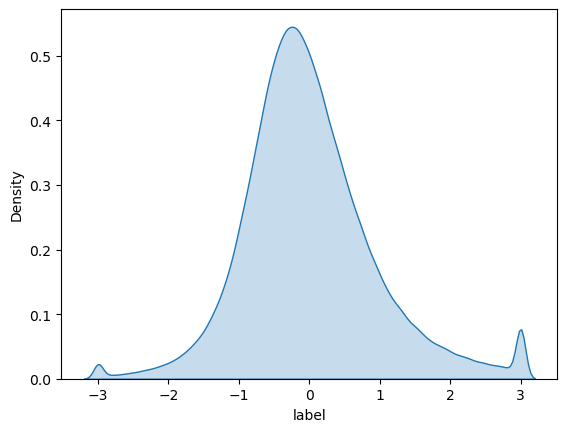

The distribution of y_valid:


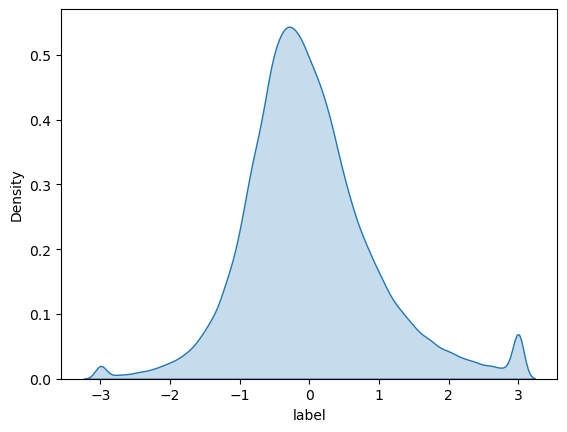

The distribution of y_test:


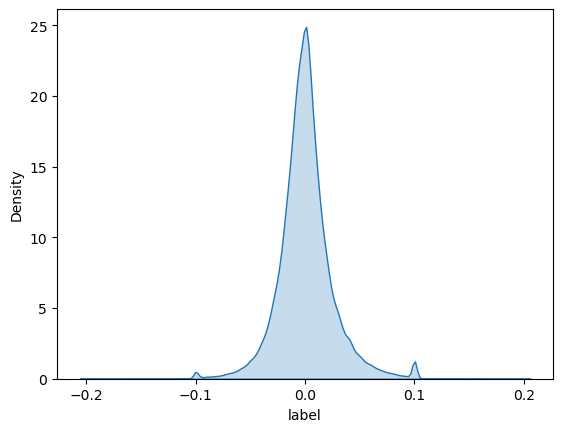

norm data done 

all works done 



In [5]:
split_params = {
    "test_start_date": "2019-01-01",
    "split_method": "group_split",
    "split_kwargs":{
        "train": 0.7,
        "valid": 0.3
    }
}
# 按split_params拆分出训练集、验证集和测试集, 并在截面上进行标准化
result = q.auto_process(X, "label", groupby="instrument", split_params=split_params, select=False, orth=False, clip=5)

X_train, y_train, X_valid, y_valid = result["X_train"], result["y_train"], result["X_valid"], result["y_valid"]
X_test, y_test, ymean, ystd = result["X_test"], result["y_test"], result["ymean"], result["ystd"]

对选定的因子进行中性化(目前版本对内存的要求很高, 但有时候确实能带来一些提升)

In [6]:
#X_train = alpha.factor_neutralize(X_train, df["amount"], features=X_train.columns[0: 20])
#X_valid = alpha.factor_neutralize(X_valid, df["amount"], features=X_train.columns[0: 20])
#X_test = alpha.factor_neutralize(X_test, df["amount"], features=X_train.columns[0: 20])
#X_train

In [7]:
# 查看数据处理的结果
X_train.describe()

,open5,open10,open20,open30,open60,close5,close10,close20,close30,close60,...,vstd5,vstd10,vstd20,vstd30,vstd60,vsump5,vsump10,vsump20,vsump30,vsump60
count,574503.000000,574503.000000,574503.000000,574503.000000,574503.000000,574503.000000,574503.000000,574503.000000,574503.000000,574503.000000,...,574503.000000,574503.000000,574503.000000,574503.000000,574503.000000,574503.000000,574503.000000,574503.000000,574503.000000,574503.000000
mean,-0.008788,-0.009226,-0.008653,-0.008091,-0.006204,-0.009278,-0.009603,-0.008851,-0.008236,-0.006269,...,-0.008672,-0.008706,-0.008574,-0.008612,-0.008546,-0.004563,-0.000979,-0.000169,-0.000071,-0.000010
std,0.916868,0.920062,0.930164,0.937268,0.953888,0.910801,0.916017,0.928183,0.935911,0.953409,...,0.923893,0.923580,0.925307,0.925899,0.925383,0.967905,0.992381,0.997198,0.997773,0.998102
min,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,...,-3.292014,-2.276954,-1.951713,-1.970956,-2.332857,-2.892230,-3.129517,-3.782953,-4.041293,-4.733265
25%,-0.457165,-0.469900,-0.492778,-0.508553,-0.532405,-0.444126,-0.463643,-0.488104,-0.505893,-0.531487,...,-0.587424,-0.610141,-0.612719,-0.610659,-0.613180,-0.654635,-0.698091,-0.701395,-0.695816,-0.682279
50%,0.012425,-0.005371,-0.035018,-0.051936,-0.080198,0.007660,-0.007978,-0.036357,-0.053022,-0.080944,...,-0.187282,-0.196987,-0.186296,-0.183326,-0.175948,-0.217640,-0.159713,-0.112398,-0.088900,-0.056839
75%,0.465639,0.451358,0.434977,0.424960,0.411975,0.452332,0.443554,0.430267,0.420316,0.410439,...,0.279747,0.297655,0.320524,0.330150,0.349646,0.396331,0.518994,0.580101,0.602067,0.623886
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [8]:
# 拟合模型
model = q.auto_lgbm(X_train, y_train, X_valid, y_valid, early_stopping=50)

pred = model.predict(X_test)
pred = pd.DataFrame(pred, columns=["predict"], index=X_test.index)
pred["predict"] += ymean.groupby("datetime").shift(2).fillna(0.0002)  # 为防止数据泄露, 使用滞后2阶的mean和std还原预测值
pred["predict"] *= ystd.groupby("datetime").shift(2).fillna(0.0189)
pred.describe()

Training until validation scores don't improve for 50 rounds
[20]	train's l2: 0.880964	valid's l2: 0.87917
[40]	train's l2: 0.878243	valid's l2: 0.878465
[60]	train's l2: 0.876222	valid's l2: 0.878102
[80]	train's l2: 0.874511	valid's l2: 0.877841
[100]	train's l2: 0.872917	valid's l2: 0.87765
[120]	train's l2: 0.871444	valid's l2: 0.877497
[140]	train's l2: 0.870062	valid's l2: 0.877345
[160]	train's l2: 0.868649	valid's l2: 0.877203
[180]	train's l2: 0.867362	valid's l2: 0.877126
[200]	train's l2: 0.866155	valid's l2: 0.877057
[220]	train's l2: 0.865001	valid's l2: 0.876999
[240]	train's l2: 0.86379	valid's l2: 0.876955
[260]	train's l2: 0.862615	valid's l2: 0.876903
[280]	train's l2: 0.861506	valid's l2: 0.876848
[300]	train's l2: 0.860467	valid's l2: 0.876825
[320]	train's l2: 0.859426	valid's l2: 0.876802
[340]	train's l2: 0.858344	valid's l2: 0.876792
[360]	train's l2: 0.857425	valid's l2: 0.8768
[380]	train's l2: 0.856331	valid's l2: 0.876809
[400]	train's l2: 0.85535	valid's l2

,predict
count,273702.000000
mean,-0.000147
std,0.001620
min,-0.010622
25%,-0.001084
50%,-0.000123
75%,0.000831
max,0.007755


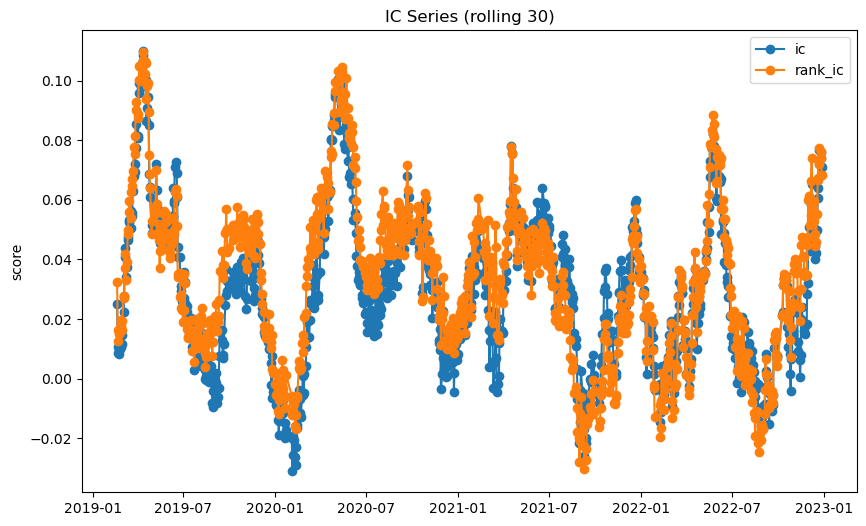

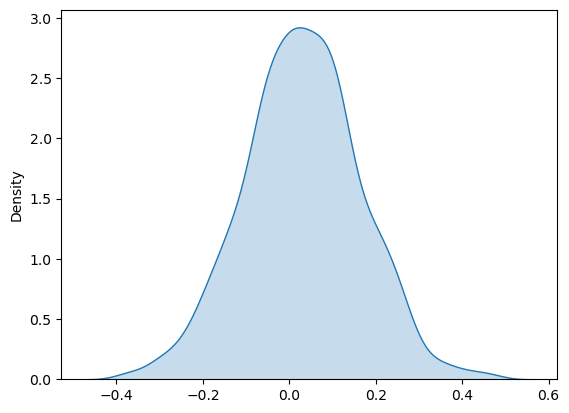

ic= 0.0291993215900394 icir= 0.217138103858726 rank_ic= 0.03313976427896842 rank_icir= 0.24376814922569606


0.027199209779890737

In [9]:
# 使用IC评判拟合优度
ic, icir, rank_ic, rank_icir = q.ic_ana(pred, y_test, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)
# 使用pearson相关系数评判拟合优度
r = q.pearson_corr(pred["predict"], y_test)
r

In [10]:
# 以下为回测部分
# 将预测值处理成回测需要的格式(需要知道预测值"predict", 交易价格price和交易量volume)
df_test = df[df.index.get_level_values(0) >= "2019-01-01"]
pred = executor.prepare(pred, df_test, price='mean_price', volume='vol', real_ret=y_test)

Accuracy of Prediction: 0.5283422812160338


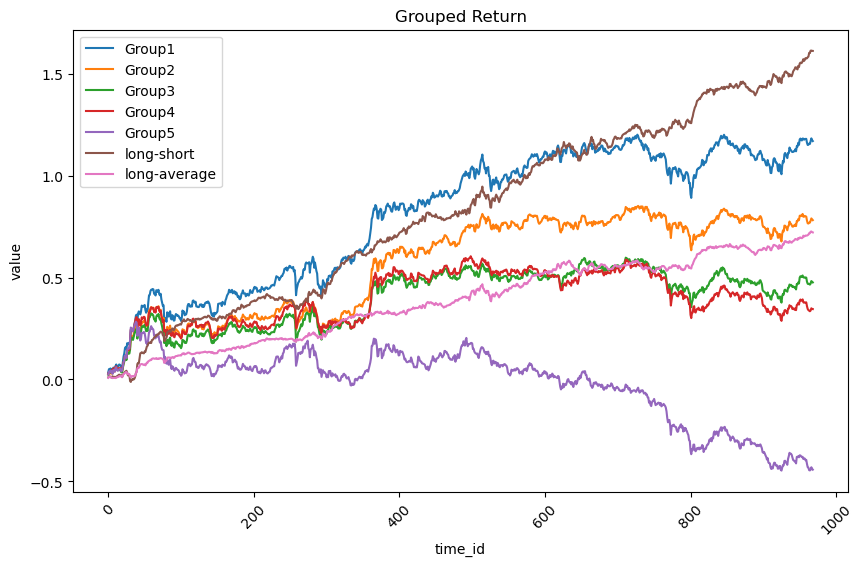

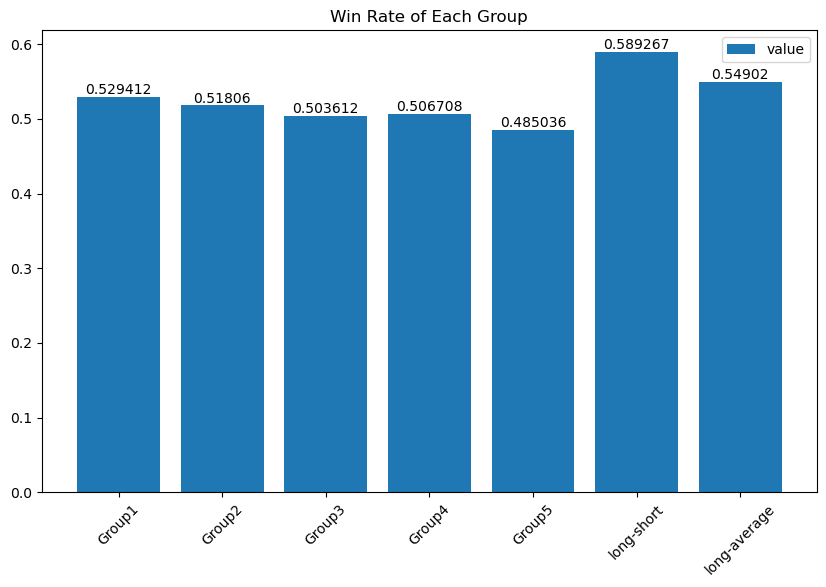

In [11]:
# 如果出现明显的分层, 则说明因子有良好的选股能力
report.group_return_ana(pred, y_test)

目前测得的策略容量以1亿(或者更少)为佳

In [12]:
backtest = {
    "generator": {
        "mode": "generate"
    },
    "strategy": {
        "class": "TopKStrategy",  # 做多预测值前20%股票, 做空后20%的股票. 自动平仓
        "kwargs": {
            "k": 0.2,
            "auto_offset": False,
            "offset_freq": 2, # 应为delta_t + 1, 例如目标值是close_-2 / close_-1 - 1, 则delta_t = 1
            "buy_only": False,  # =True时，只做多不做空(在A股做空有一定的难度)
            "short_volume": 500, # 融券做空的数量
            "risk_degree": 0.95,  # 将风险度控制在这个数，如果超过了就按比例减持股票直到风险度小于等于它为止
            "unit": None,  # 由于数据已经是以手为单位, 故无需二次处理
            "max_volume": 0.05  # 手数随可用资金而改变，最大不会超过股票当天成交量的1%(例如T+1时下单，下单手数不会超过T时成交量的1%)
        }
    },
    "account": None, # 使用默认账户, 即初始资金为1亿, 无底仓 (注意策略容量！)
    "trade_params": {
        "cost_buy": 0.0015,  # 佣金加上印花税
        "cost_sell": 0.0015,  
        "min_cost": 5,
    }
}
generator, strategy, account, trade_params = backtest["generator"], backtest["strategy"], backtest["account"], backtest["trade_params"]
exe = executor.Executor(generator, strategy, account, trade_params)
exe.execute(data=pred, verbose=0)  # verbose=1时，按时间输出买卖指令

Annualized Return: 0.10097669424274724
Annualized Volatility: 0.08668164580731043
Annualized Return(Benchmark): 0.09339936134769511
Annualized Volatility(Benchmark): 0.09285393899807326 

Cumulative Rate of Return: 0.4475942218167144
Cumulative Rate of Return(Benchmark): 0.4096580641516545
Cumulative Excess Rate of Return: 0.037936157665059866 

Max Drawdown: -0.2526187959624684
Max Drawdown(Benchmark): -0.2655417816463426
Max Drawdown(Excess Return): -0.1926227613746149 

Sharpe Ratio: 2.351950080192944
Sortino Ratio: -0.1975339316047726
Information Ratio: -0.20770367859566288 

Beta: 0.9136051876028389
Alpha: 0.002290992123664015
Epsilon: 0.034928005166509554
Profitable Days(%): 0.18472652218782248


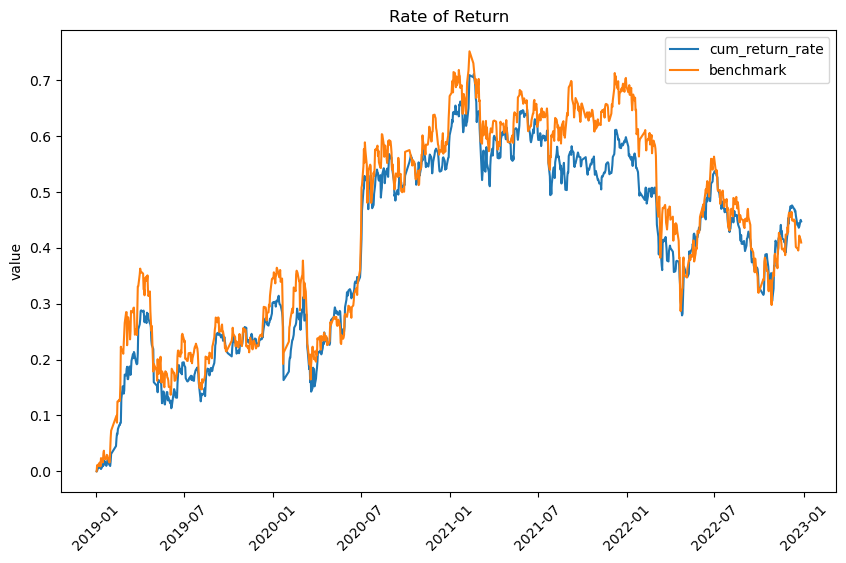

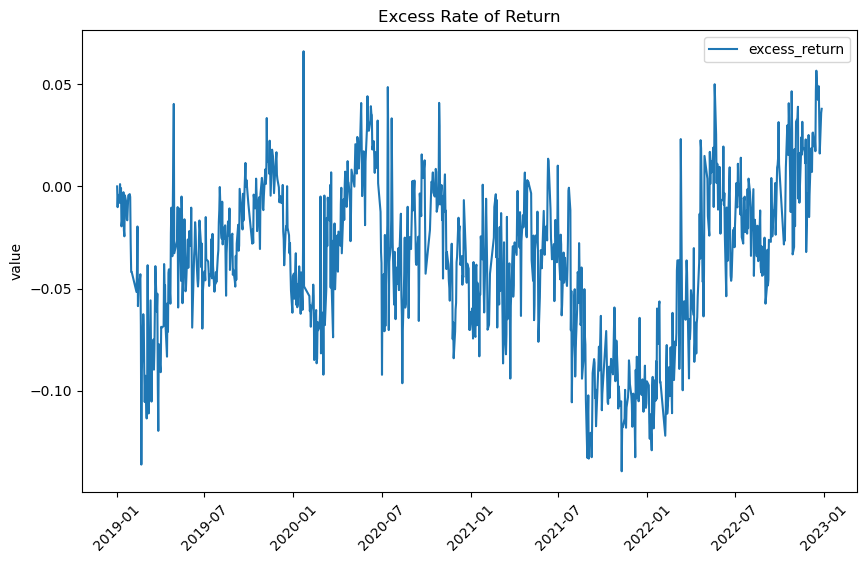

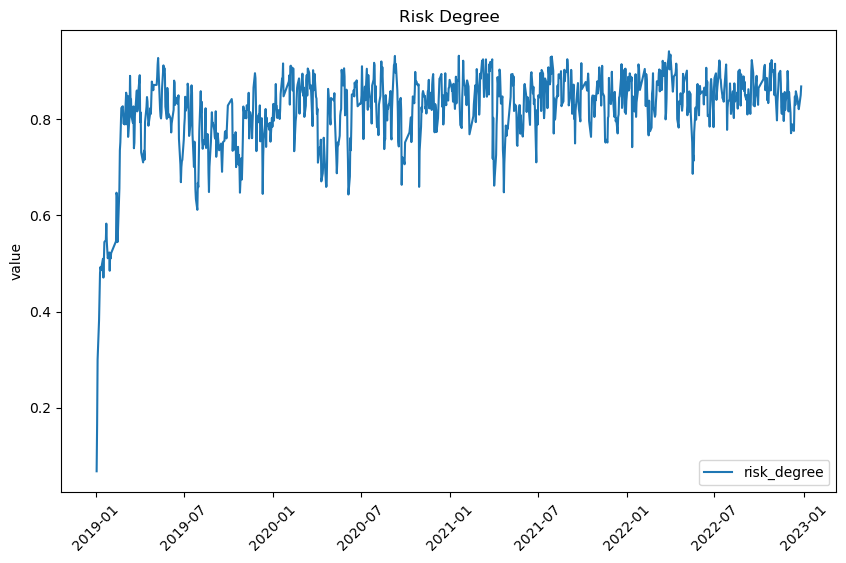

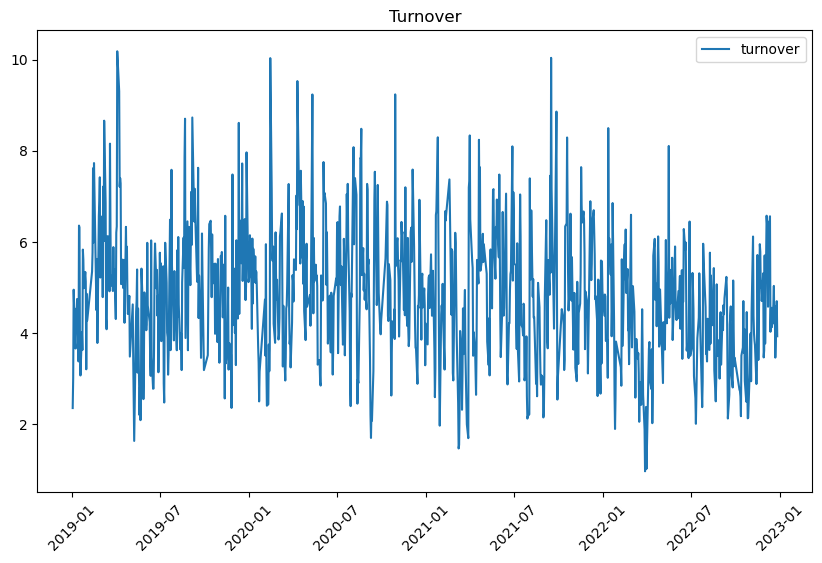

In [13]:
# 报告回测结果
user_account, benchmark = exe.user_account, exe.benchmark
report.report_all(user_account, benchmark, freq=1, time=exe.time)  # 无风险收益率默认为年化3%，可以通过参数rf调节

In [14]:
# user_account.buy_hist # 查看历史上所有买单